In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [16]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [17]:
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [18]:
# plot images
def plotImages(images):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss And Accuracy")
    plt.ylabel("Loss/Accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

In [20]:
# Processing The Image Datasets
classes = ["Clam", "Crab", "Dolphin", "Eel", "Fish", "Jelly Fish", "Lobster", "Octopus", "Otter", "Puffer", "Sea Horse","Sea Ray", "Sea Turtle", "Sea Urchin", "Seal", "Shark", "Shrimp", "Squid", "Starfish","Whale"]

train_path = '/kaggle/input/marine-animals-dataset/train'
valid_path = '/kaggle/input/marine-animals-dataset/valid'
test_path = '/kaggle/input/marine-animals-dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False)

Found 40504 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 399 images belonging to 20 classes.


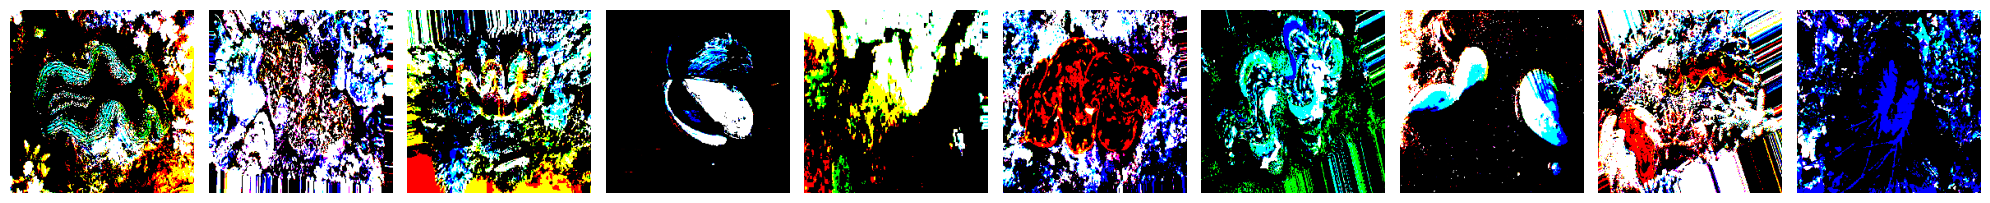

In [21]:
imgs, label = next(test_batches)
plotImages(imgs)

In [33]:
base_model = tf.keras.applications.ResNet101(weights='imagenet')
# base_model.trainable = False
base_model.summary()

179648224/179648224 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 44,707,176 (170.54 MB)

 Trainable params: 44,601,832 (170.14 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [43]:
x = base_model.layers[-3].output
x = GlobalAveragePooling2D()(x)
# x = Dense(units=256, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(units=20, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = output)

In [44]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [36]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,253,652 (165.00 MB)

 Trainable params: 6,115,860 (23.33 MB)

 Non-trainable params: 37,137,792 (141.67 MB)

In [45]:
optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, weight_decay=0.01/40)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
 361/1266 ━━━━━━━━━━━━━━━━━━━━ 2:36 173ms/step - accuracy: 0.1738 - loss: 2.9722

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1266/1266 ━━━━━━━━━━━━━━━━━━━━ 246s 177ms/step - accuracy: 0.4586 - loss: 2.0007 - val_accuracy: 0.9350 - val_loss: 0.3552
Epoch 2/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 198s 155ms/step - accuracy: 0.9338 - loss: 0.3362 - val_accuracy: 0.9490 - val_loss: 0.2585
Epoch 3/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 202s 159ms/step - accuracy: 0.9580 - loss: 0.1983 - val_accuracy: 0.9470 - val_loss: 0.2413
Epoch 4/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 202s 158ms/step - accuracy: 0.9716 - loss: 0.1379 - val_accuracy: 0.9500 - val_loss: 0.2446
Epoch 5/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 199s 156ms/step - accuracy: 0.9759 - loss: 0.1117 - val_accuracy: 0.9500 - val_loss: 0.2169
Epoch 6/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 203s 160ms/step - accuracy: 0.9796 - loss: 0.0955 - val_accuracy: 0.9530 - val_loss: 0.2181
Epoch 7/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 200s 157ms/step - accuracy: 0.9820 - loss: 0.0804 - val_accuracy: 0.9510 - val_loss: 0.2194
Epoch 8/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 200s 157ms/step - accuracy: 0.9

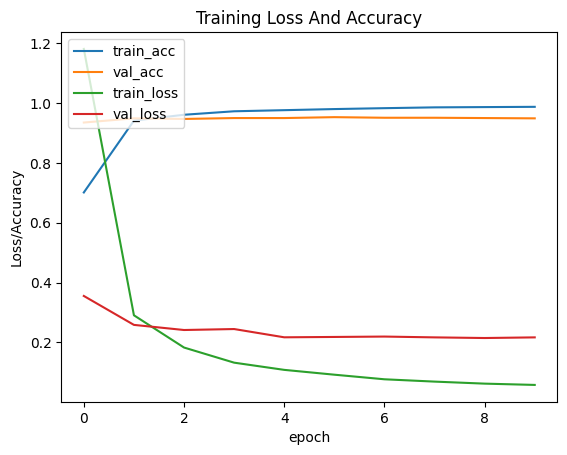

In [46]:
H = model.fit(x=train_batches, validation_data=valid_batches, epochs=10)
plot_hist(H)

In [47]:
test_labels = test_batches.classes

In [48]:
predict = model.predict(x=test_batches, verbose=0)

In [49]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predict, axis=-1))

In [31]:
test_batches.class_indices

{'Clam': 0,
 'Crab': 1,
 'Dolphin': 2,
 'Eel': 3,
 'Fish': 4,
 'Jelly Fish': 5,
 'Lobster': 6,
 'Octopus': 7,
 'Otter': 8,
 'Puffer': 9,
 'Sea Horse': 10,
 'Sea Ray': 11,
 'Sea Turtle': 12,
 'Sea Urchin': 13,
 'Seal': 14,
 'Shark': 15,
 'Shrimp': 16,
 'Squid': 17,
 'Starfish': 18,
 'Whale': 19}

Confusion matrix, without normalization


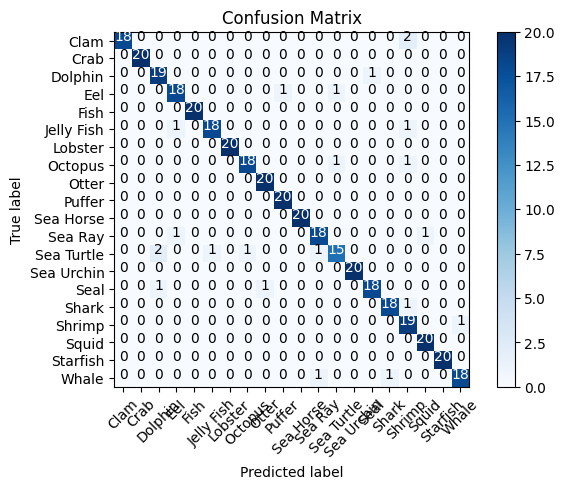

In [50]:
cm_plot_labels = ["Clam", "Crab", "Dolphin", "Eel", "Fish", "Jelly Fish", "Lobster", "Octopus", "Otter", "Puffer", "Sea Horse","Sea Ray", "Sea Turtle", "Sea Urchin", "Seal", "Shark", "Shrimp", "Squid", "Starfish","Whale"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [52]:
model.save("Marine_Animals_ResNet101_Tuned_Model_95.h5")

In [53]:
from IPython.display import FileLink
FileLink(r'Marine_Animals_ResNet101_Tuned_Model_95.h5')

/kaggle/working/Marine_Animals_ResNet101_Tuned_Model_95.h5